## Import necessary libraries and methods

In [1]:
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras import layers, Sequential
from keras.optimizer_experimental.adam import Adam
from keras.engine.training import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img
from keras.applications.resnet import ResNet101
from keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], False)

## Download Caltech dataset and prepare data for training

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 30
# download data from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "caltech-101/caltech-101/101_ObjectCategories",
    seed=1234,
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 9144 files belonging to 102 classes.


Let's see what photos we are having in our dataset:

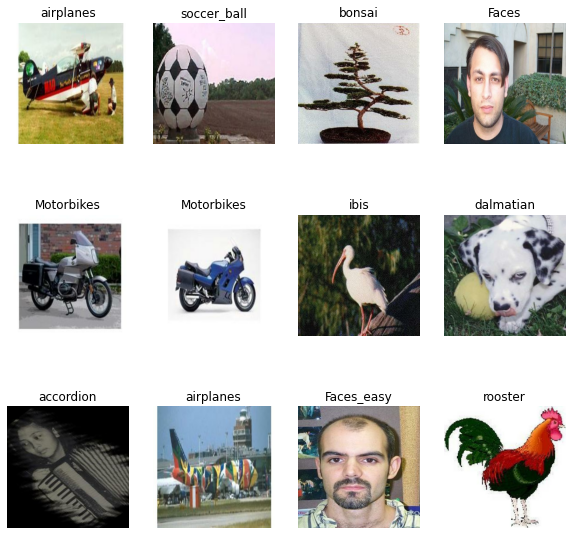

In [4]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis("off")

Function for dividing data into three datasets: training, testing, validating

In [5]:
def get_dataset_partitions(ds, train_split=0.7, val_split=0.2, shuffle = True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

Shuffling data in every dataset:

In [7]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = Sequential([
    layers.preprocessing.image_preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.preprocessing.image_preprocessing.Rescaling(1.0/255)
])

data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Functions for analyzing models

###1. How to make classification report

In [9]:
def get_classification_report(mdl):
    y_trues, preds = get_true_labels_and_preds(test_dataset, mdl)
    print(classification_report(y_trues, preds))

###2. How to build learning curves

In [10]:
def build_learning_curves(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]

    loss = model_history.history["loss"]
    loss_acc = model_history.history["val_loss"]

    run_epochs = len(loss)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(run_epochs), acc, label="Training Accuracy")
    plt.plot(range(run_epochs), val_acc, label="Validation Accuracy")
    plt.legend(loc="lower center")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(range(run_epochs), loss, label="Training Loss")
    plt.plot(range(run_epochs), loss_acc, label="Validation Loss")
    plt.legend(loc="lower center")
    plt.title("Training and Validation Loss")
    plt.show()

###3. How to plot confusion matrix:

In [11]:
def get_true_labels_and_preds(ds, mdl):
    rounded_predictions = np.argmax(mdl.predict(ds), axis=-1)
    true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    return rounded_predictions, true_labels

In [12]:
def plot_confusion_matrix(mdl):
    y_trues, preds = get_true_labels_and_preds(test_dataset, mdl)
    cm = confusion_matrix(y_trues, preds)

    fig, ax = plt.subplots(figsize=(27,25))
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax)

###4. How to plot ROC curve

In [13]:
def plot_roc_curve(mdl):
    y_trues, preds = get_true_labels_and_preds(test_dataset, mdl)
    fpr, tpr, threshold = roc_curve(y_trues, preds, pos_label=1)
    auc_keras = auc(fpr, tpr)

    plt.figure(figsize=(17,12))
    plt.plot(fpr, tpr, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

###5. How to plot AUC-PRC curve

In [14]:
def plot_precision_recall_curve(mdl):
    y_trues, preds = get_true_labels_and_preds(test_dataset, mdl)
    recall, precision, _ = precision_recall_curve(y_trues, preds, pos_label=1)
    fpr, tpr, threshold = roc_curve(y_trues, preds, pos_label=1)
    auc_keras = auc(fpr, tpr)

    plt.figure(figsize=(17,12))
    plt.plot(recall, precision, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras, color="red", linewidth=3)

###6. How to visualize filters and corresponding feature maps of the first and second Conv2d layers

In [15]:
lst = ["First", "Second"]
def get_first_second_layers(mdl):
    lst = [l for l in mdl.layers if isinstance(l, layers.Conv2D)]
    return [lst[0], lst[2]]

In [16]:
def visualize_layer_filters(mdl, layer_num):
    # retrieve weights from the second hidden layer
    print(layer_num)
    filters, biases = mdl.layers[layer_num].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 9, 1
    plt.figure(figsize=(12, 12))
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

In [17]:
def visualize_filters(mdl):
    for num, lyr in zip(lst, get_first_second_layers(mdl)):
        print(f"{num} Conv2D layer")
        visualize_layer_filters(mdl, mdl.layers.index(lyr))

###7. How to visualize corresponding feature maps of the first and second Conv2d layers

In [18]:
def get_rand_image_from_directory(DIR):
    imgs = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    return random.choice(imgs)

def visualize_fm_for_single_lyr(mdl, layer_num, img):
    # redefine model to output right after the first hidden layer
    feature_map_model = Model(inputs=mdl.inputs, outputs=mdl.layers[layer_num].output)
    # feature_map_model.summary()

    # convert the image to an array expand dimensions
    img = np.expand_dims(img_to_array(img), axis=0)

    feature_maps = feature_map_model.predict(img)
    # plot all 64 maps in an 10x10 squares
    if layer_num == 2:
        d1, d2 = 8, 4
    else:
        d1, d2 = 8, 8
    ix = 1
    plt.figure(figsize=(12, 12))
    for _ in range(d1):
        for _ in range(d2):
            # specify subplot and turn of axis
            ax = plt.subplot(d1, d2, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix - 1])
            ix += 1
    plt.show()

In [19]:
def visualize_feature_maps(mdl):
    rand_img = get_rand_image_from_directory("Caltech101/testAll_v2")
    img = load_img(f"Caltech101/testAll_v2/{rand_img}", target_size=(224, 224))
    plt.imshow(img)
    plt.title("Original image")

    for num, lyr in zip(lst, get_first_second_layers(mdl)):
        print(f"{num} Conv2D layer")
        visualize_fm_for_single_lyr(mdl, mdl.layers.index(lyr), img)

# Plain 3-layer CNN

Let's define model architecture:

In [52]:
n_classes = 102
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

plain_cnn_model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    layers.BatchNormalization(trainable=True),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same",),
    layers.BatchNormalization(trainable=True),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same",),
    layers.BatchNormalization(trainable=True),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(204, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation="softmax")
])

plain_cnn_model.build(input_shape=input_shape)

In [53]:
plain_cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 128, 128, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (32, 128, 128, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 64, 64, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 64, 64, 64)         

Compiling the model with Adam optimizer and sparse categorical crossentrop loss:

In [54]:
plain_cnn_model.compile(
    optimizer = "Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)]
)

Define early stopping to stop training the model if validation loss starts to increase:

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Training the model on train_dataset:

In [56]:
EPOCHS = 50
history = plain_cnn_model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset,
    callbacks=[es]
)

Epoch 1/50
200/200 [==============================] - 87s 423ms/step - loss: 3.1650 - accuracy: 0.3467 - sparse_top_k_categorical_accuracy: 0.3467 - val_loss: 5.2896 - val_accuracy: 0.0110 - val_sparse_top_k_categorical_accuracy: 0.0110
Epoch 2/50
200/200 [==============================] - 11s 56ms/step - loss: 2.2854 - accuracy: 0.4759 - sparse_top_k_categorical_accuracy: 0.4759 - val_loss: 2.7118 - val_accuracy: 0.4030 - val_sparse_top_k_categorical_accuracy: 0.4030
Epoch 3/50
200/200 [==============================] - 11s 56ms/step - loss: 1.8402 - accuracy: 0.5580 - sparse_top_k_categorical_accuracy: 0.5580 - val_loss: 1.8336 - val_accuracy: 0.5625 - val_sparse_top_k_categorical_accuracy: 0.5625
Epoch 4/50
200/200 [==============================] - 11s 55ms/step - loss: 1.5608 - accuracy: 0.6197 - sparse_top_k_categorical_accuracy: 0.6197 - val_loss: 2.0147 - val_accuracy: 0.5197 - val_sparse_top_k_categorical_accuracy: 0.5197
Epoch 5/50
200/200 [==============================] - 1

After training the model we evaluating it on the test_dataset:

In [57]:
scores = plain_cnn_model.evaluate(test_dataset)
scores

29/29 [==============================] - 1s 30ms/step - loss: 1.0506 - accuracy: 0.7866 - sparse_top_k_categorical_accuracy: 0.7866


[1.0505903959274292, 0.7866379022598267, 0.7866379022598267]

In [59]:
plain_cnn_model.save(f"models/plain_cnn")

INFO:tensorflow:Assets written to: models/plain_cnn\assets


In [82]:
from keras import models

plain_cnn_model = models.load_model(f"models/plain_cnn")

So the average score is pretty nice considering the small size of the dataset. But what about some specific images?
Let's take some random images from the first batch of testing dataset and classify it:

In [29]:
class_names = dataset.class_names
def predict(mdl, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = mdl.predict(img_array)

    pred_class = class_names[np.argmax(predictions[0])]
    conf = round(100 * (np.max(predictions[0])), 2)
    return pred_class, conf

In [31]:
def some_test_ds_predictions(model):
    plt.figure(figsize=(15, 15))
    for images, labels in test_dataset.take(1):
        for i in range(4):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", color="white")

            plt.axis("off")

# some_test_ds_predictions(plain_cnn_model)

# Classification report for plain 3-layer CNN

In [62]:
get_classification_report(plain_cnn_model)

              precision    recall  f1-score   support

           0       0.07      0.03      0.04        99
           1       0.13      0.13      0.13        45
           2       0.09      0.10      0.09        42
           3       0.00      0.00      0.00        14
           4       0.16      0.15      0.16        91
           5       0.09      0.06      0.07        17
           6       0.08      0.09      0.09        76
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         3
           9       0.33      0.25      0.29         4
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         7
          17       0.00    

C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

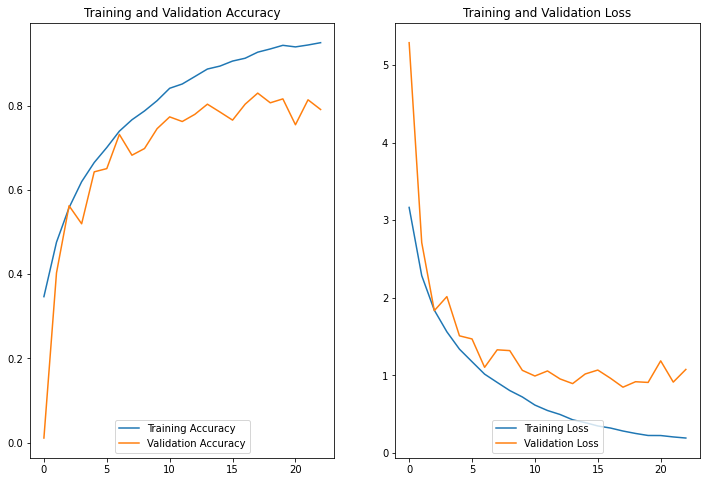

In [63]:
build_learning_curves(history)

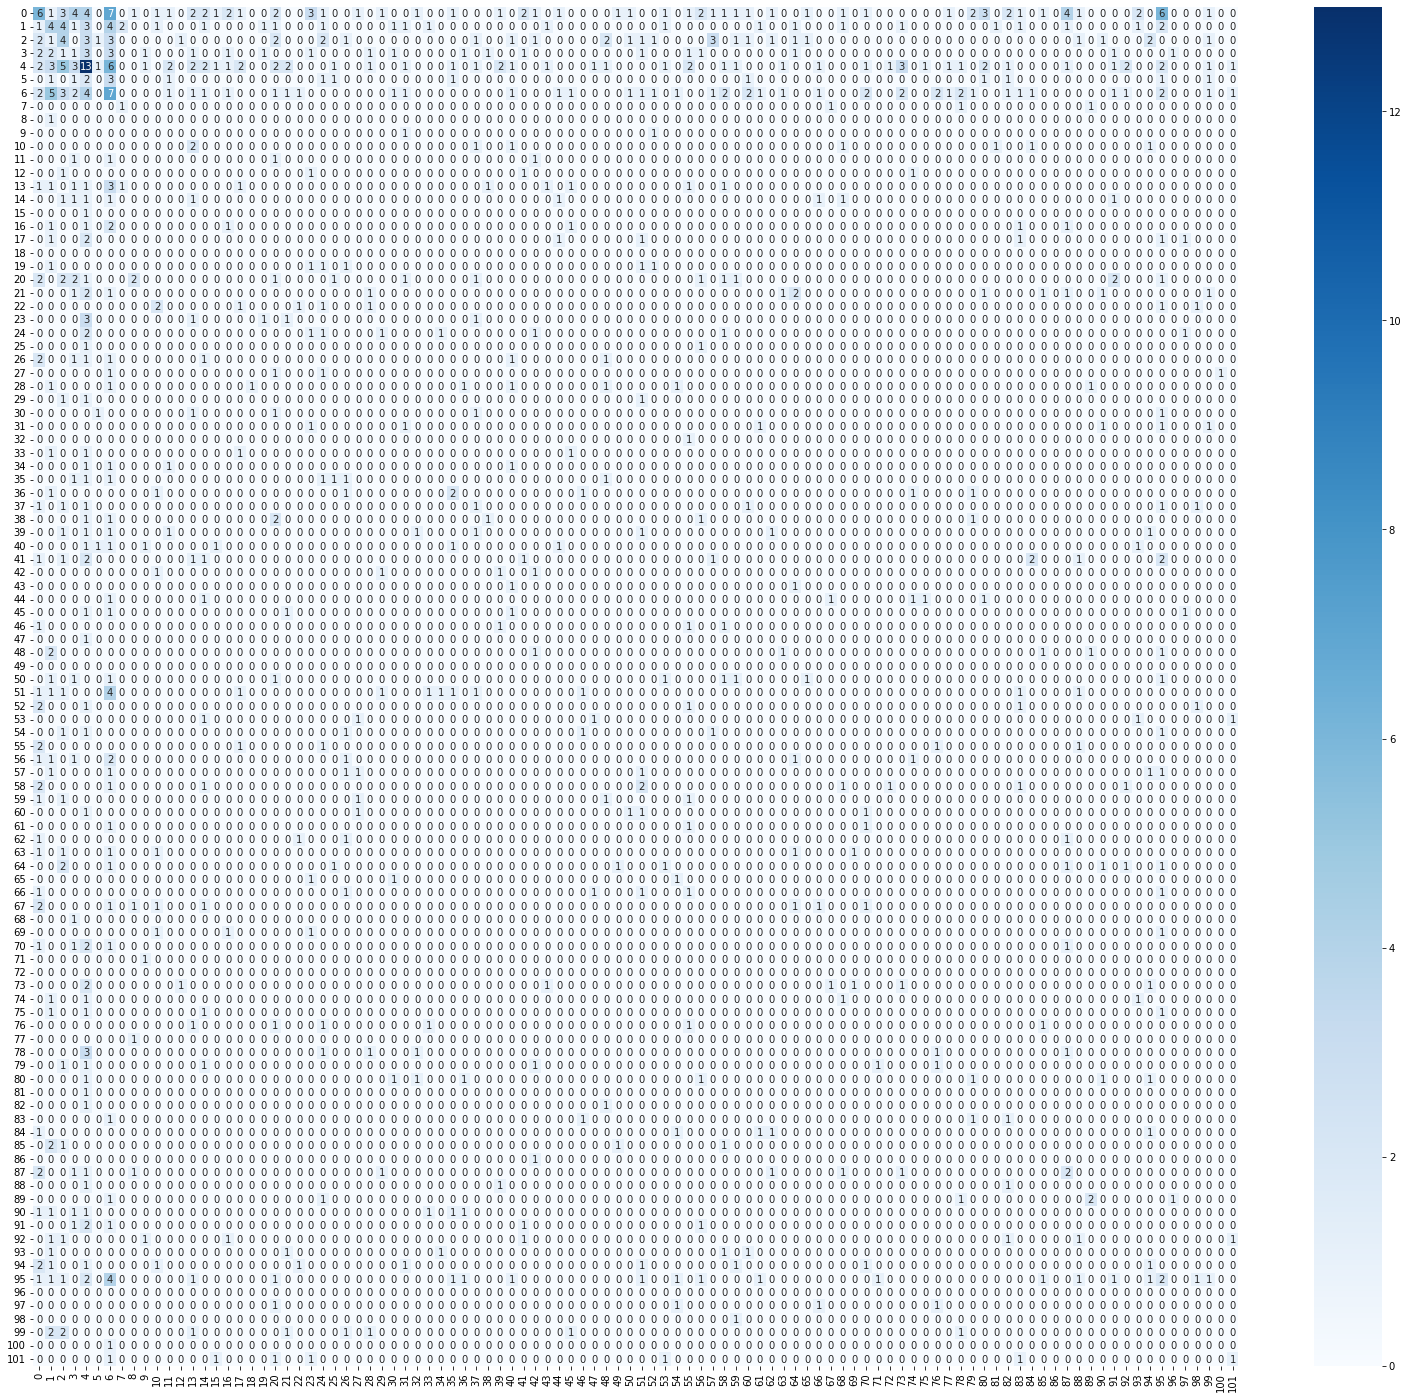

In [87]:
plot_confusion_matrix(plain_cnn_model)

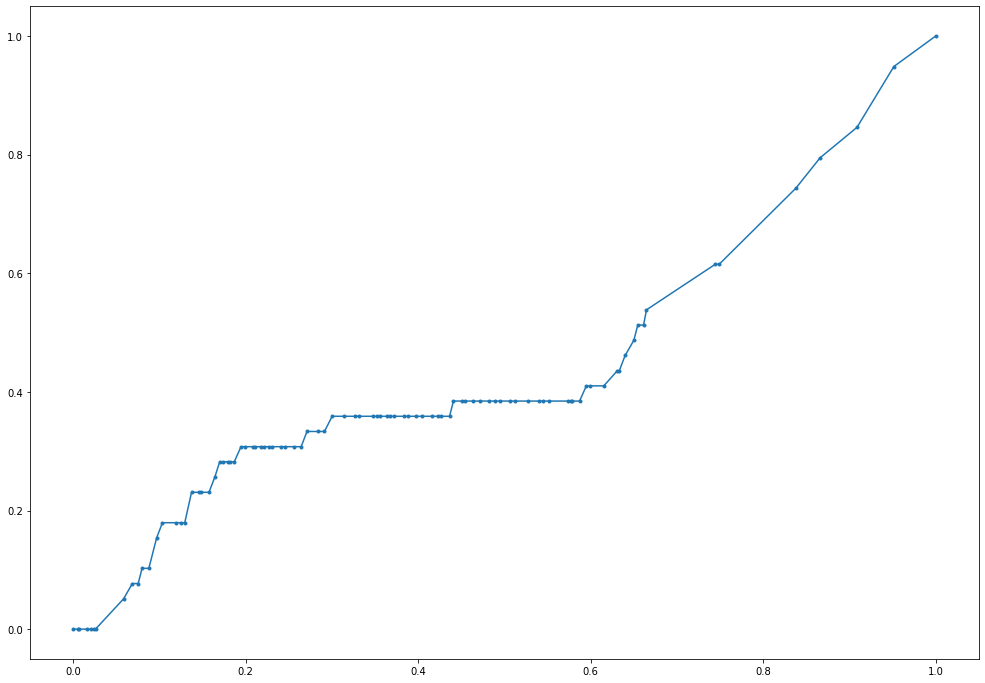

In [88]:
plot_roc_curve(plain_cnn_model)

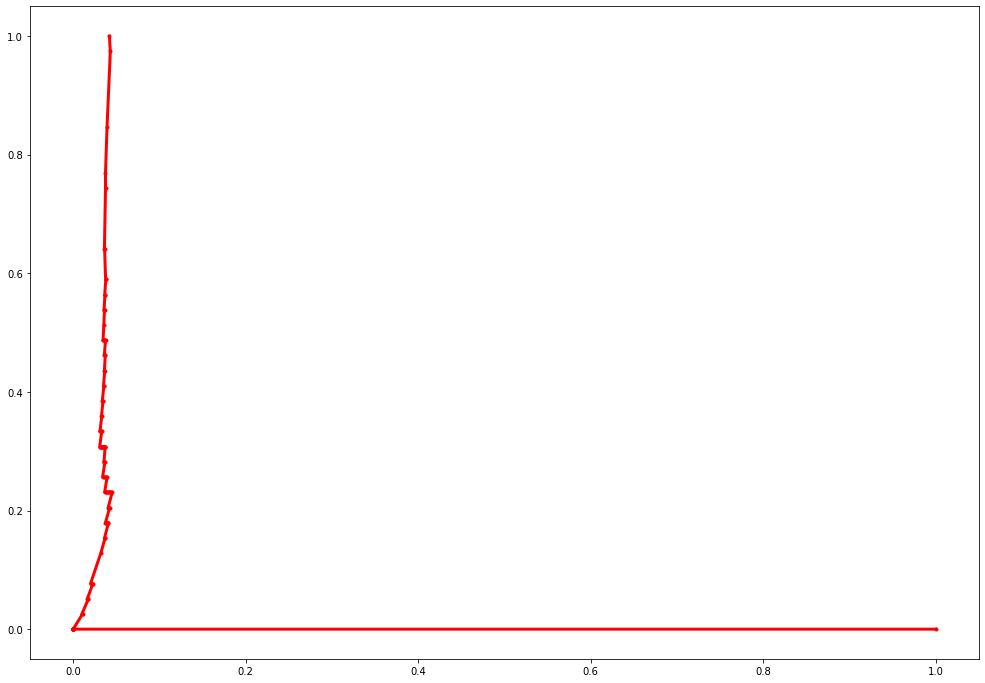

In [89]:
plot_precision_recall_curve(plain_cnn_model)

First Conv2D layer


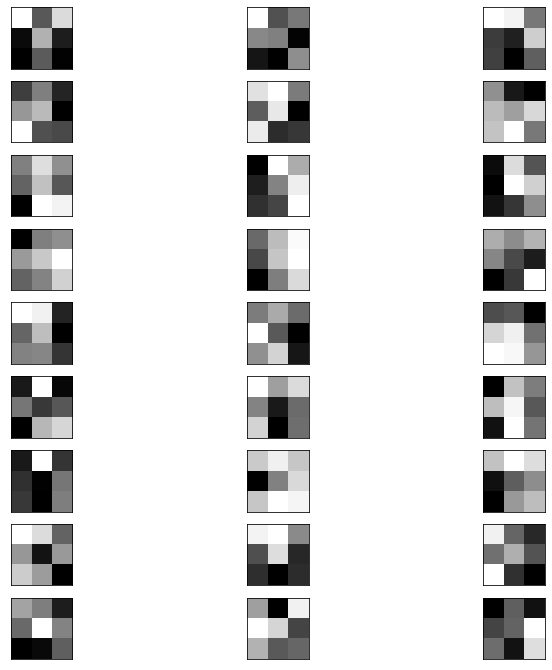

Second Conv2D layer


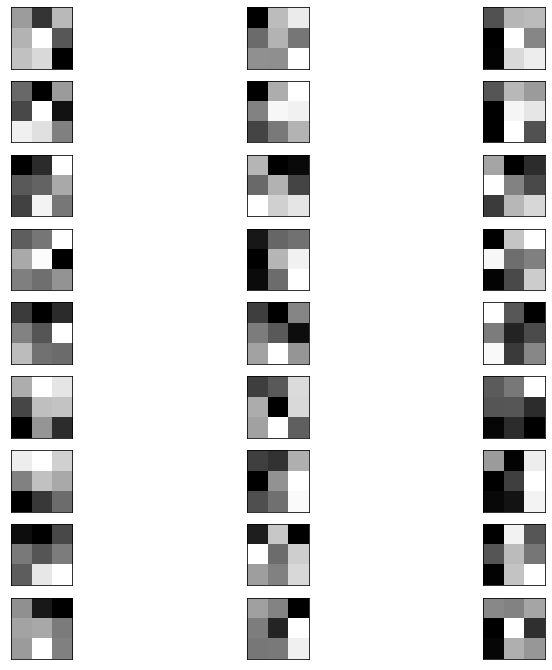

In [90]:
visualize_filters(plain_cnn_model)

First Conv2D layer


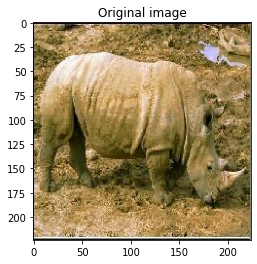

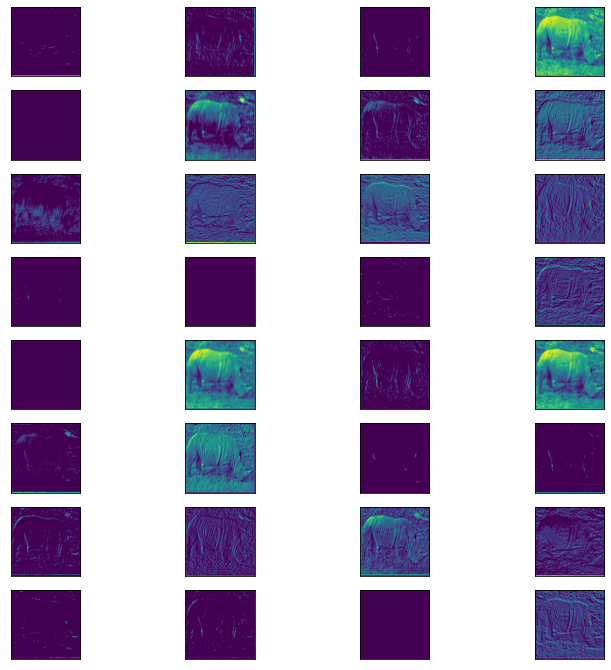

Second Conv2D layer


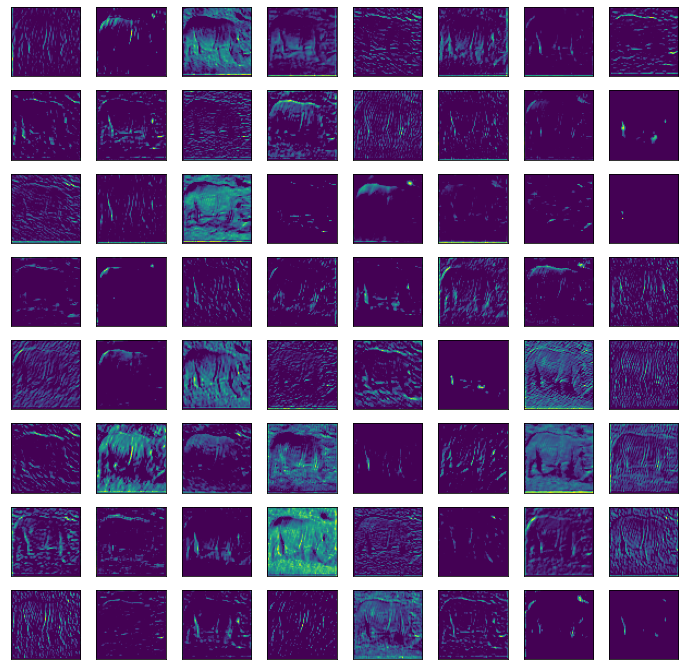

In [91]:
visualize_feature_maps(plain_cnn_model)

# Frozen pre-trained ResNet as feature extractor

Downloading ResNet101:

In [20]:
resnet_model = ResNet101(include_top=False, weights='imagenet')

In [21]:
def freeze_or_unfreeze(mdl, bol):
    for lyr in mdl.layers:
        lyr.trainable = bol

In [22]:
x = layers.GlobalAveragePooling2D()(resnet_model.output)
x = layers.Dense(1024,activation='relu')(x)
predictions = layers.Dense(102,activation = 'softmax')(x)

freeze_or_unfreeze(resnet_model, False)
frozen_resnet101 = Model(inputs=resnet_model.input,outputs=predictions)

Let's check added layers plus weather they are trainable or not:

In [23]:
frozen_resnet101.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [24]:
for layer in frozen_resnet101.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

As we can see, all layers are frozen except for last three. Now compiling this model:

In [25]:
frozen_resnet101.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)])

In [26]:
EPOCHS = 15
fr_history = frozen_resnet101.fit(train_dataset,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_dataset,
)

Epoch 1/15
200/200 [==============================] - 125s 550ms/step - loss: 0.9294 - accuracy: 0.7886 - sparse_top_k_categorical_accuracy: 0.7886 - val_loss: 0.3030 - val_accuracy: 0.9172 - val_sparse_top_k_categorical_accuracy: 0.9172
Epoch 2/15
200/200 [==============================] - 98s 492ms/step - loss: 0.1624 - accuracy: 0.9507 - sparse_top_k_categorical_accuracy: 0.9507 - val_loss: 0.2008 - val_accuracy: 0.9424 - val_sparse_top_k_categorical_accuracy: 0.9424
Epoch 3/15
200/200 [==============================] - 96s 482ms/step - loss: 0.0720 - accuracy: 0.9778 - sparse_top_k_categorical_accuracy: 0.9778 - val_loss: 0.1453 - val_accuracy: 0.9616 - val_sparse_top_k_categorical_accuracy: 0.9616
Epoch 4/15
200/200 [==============================] - 96s 481ms/step - loss: 0.0460 - accuracy: 0.9876 - sparse_top_k_categorical_accuracy: 0.9876 - val_loss: 0.1259 - val_accuracy: 0.9693 - val_sparse_top_k_categorical_accuracy: 0.9693
Epoch 5/15
200/200 [==============================]

Training the model on train dataset:

In [27]:
scores = frozen_resnet101.evaluate(test_dataset)
scores

29/29 [==============================] - 19s 391ms/step - loss: 0.0687 - accuracy: 0.9817 - sparse_top_k_categorical_accuracy: 0.9817


[0.06870429962873459, 0.9816810488700867, 0.9816810488700867]

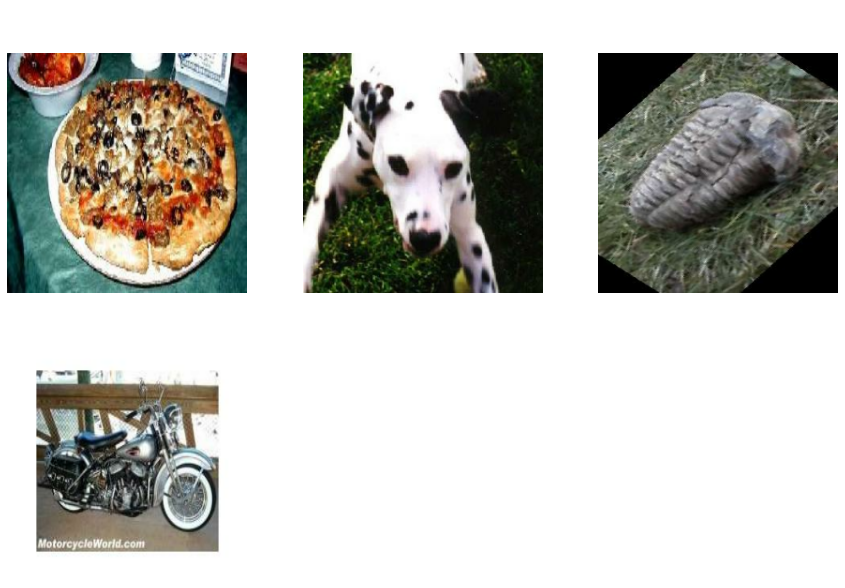

In [32]:
some_test_ds_predictions(frozen_resnet101)

In [33]:
get_classification_report(frozen_resnet101)

              precision    recall  f1-score   support

           0       0.16      0.15      0.15        47
           1       0.11      0.11      0.11        45
           2       0.19      0.18      0.18        44
           3       0.07      0.06      0.06        16
           4       0.16      0.16      0.16        88
           5       0.00      0.00      0.00        11
           6       0.18      0.18      0.18        85
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         3
          10       0.14      0.12      0.13         8
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         7
          17       0.00    

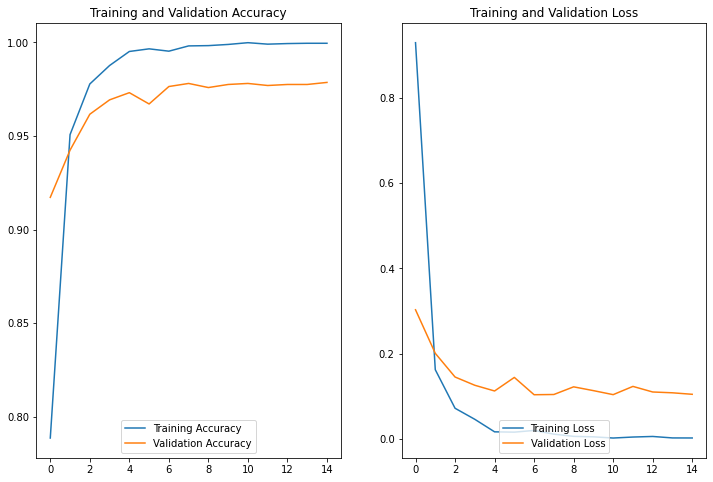

In [34]:
build_learning_curves(fr_history)

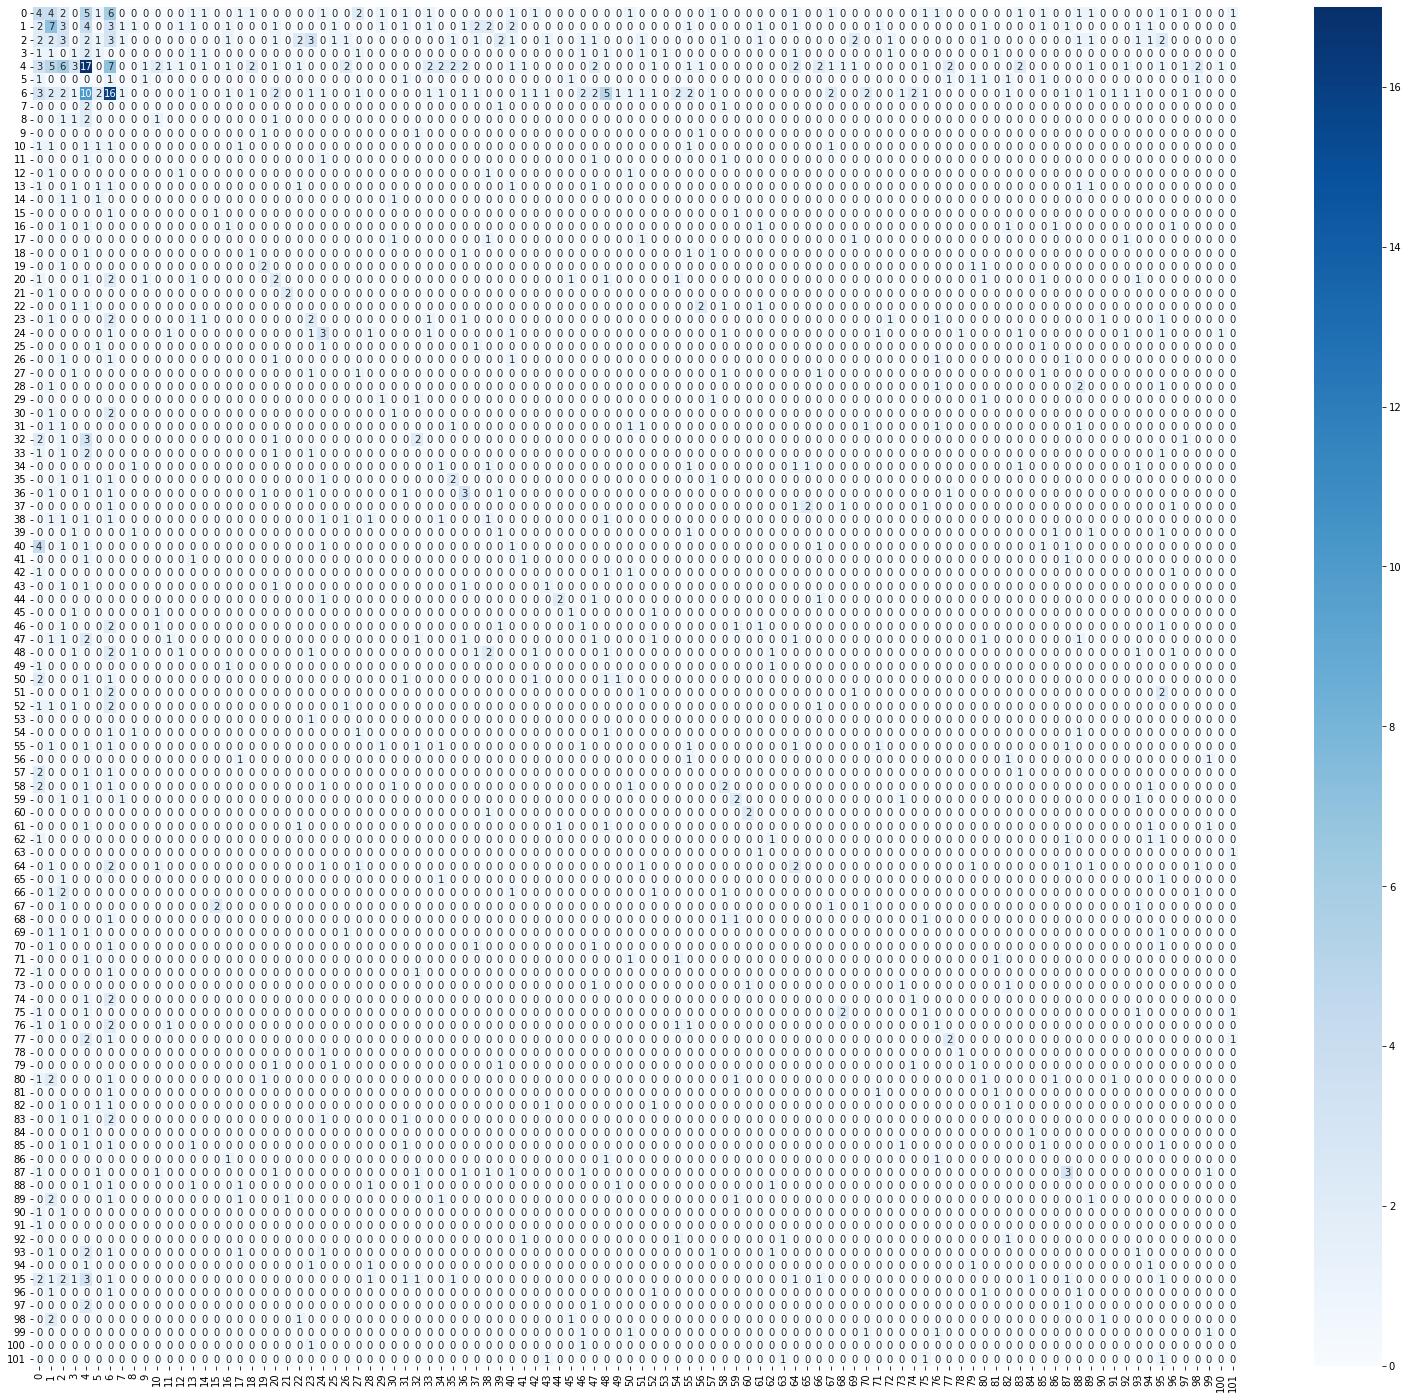

In [35]:
plot_confusion_matrix(frozen_resnet101)

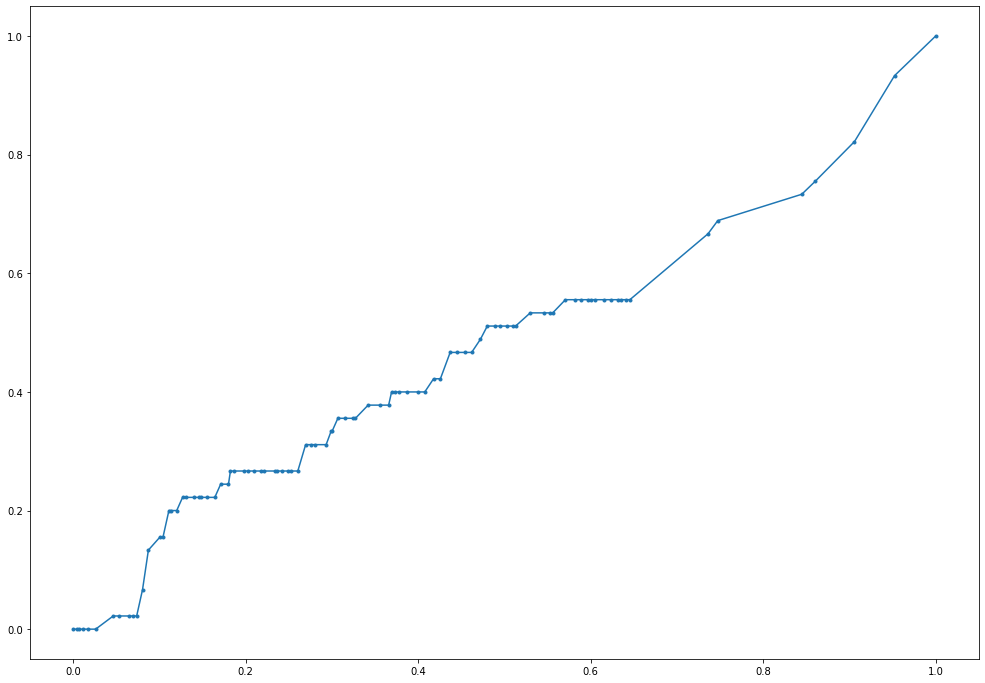

In [36]:
plot_roc_curve(frozen_resnet101)

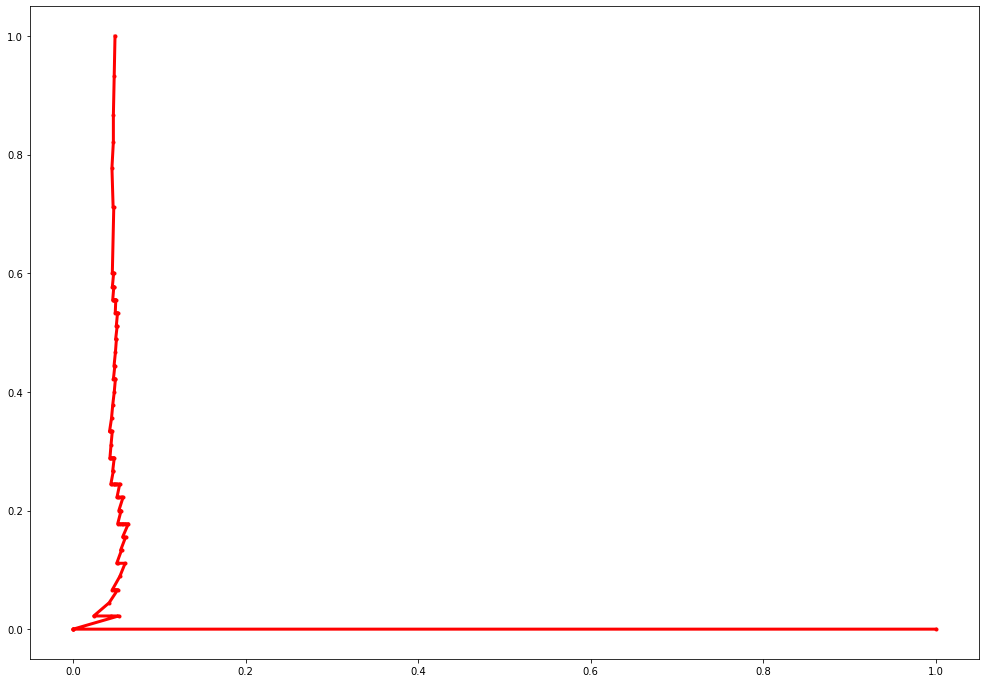

In [37]:
plot_precision_recall_curve(frozen_resnet101)

First Conv2D layer
2


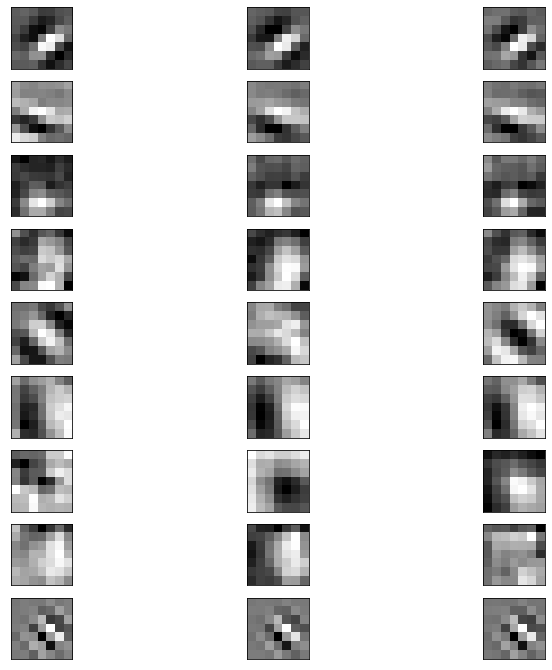

Second Conv2D layer
10


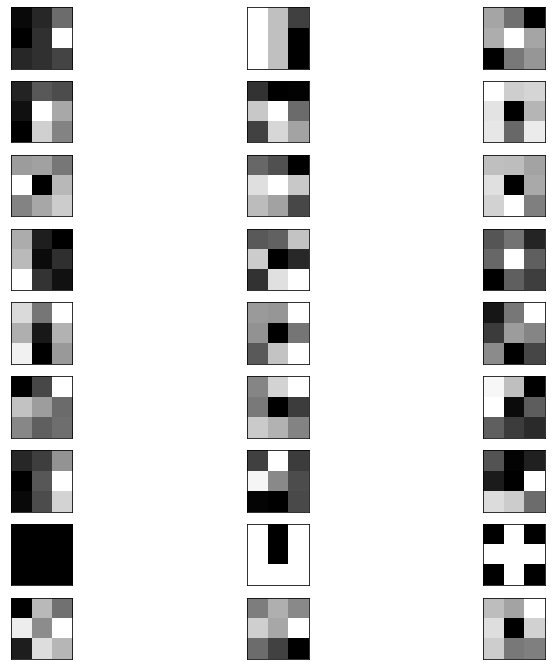

In [58]:
visualize_filters(frozen_resnet101)

First Conv2D layer


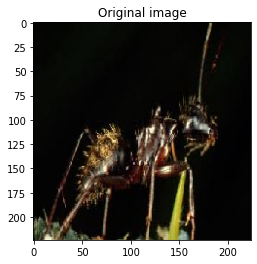

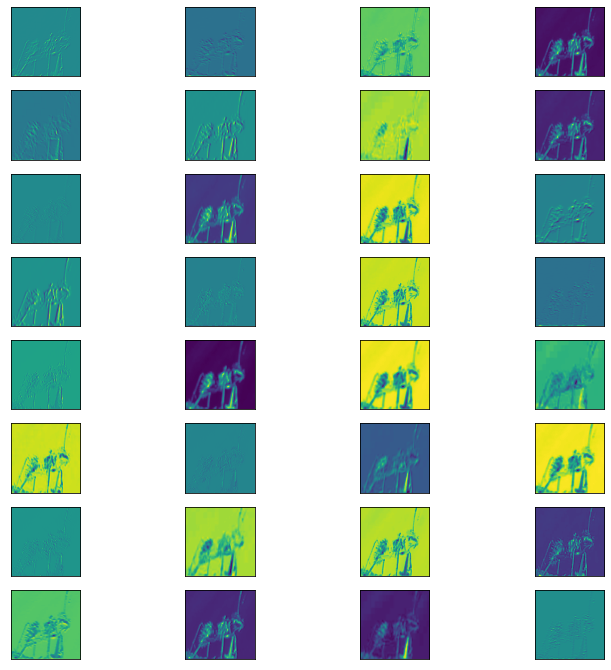

Second Conv2D layer


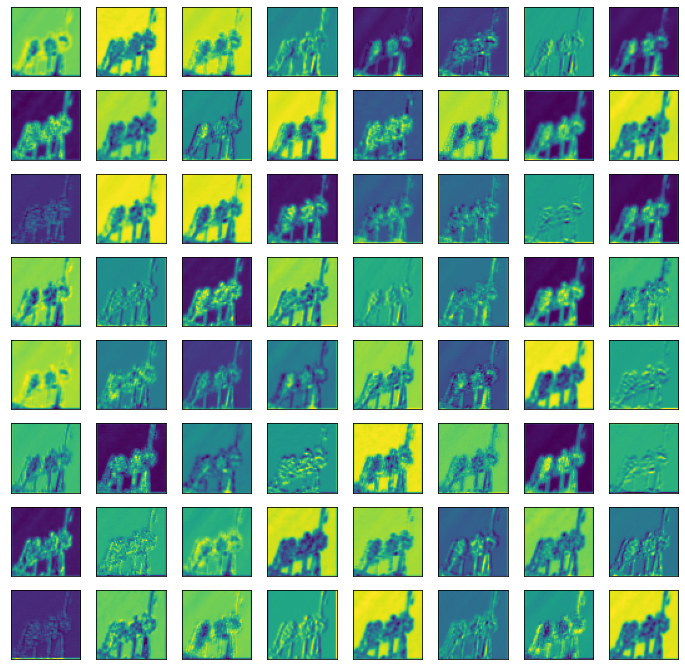

In [59]:
visualize_feature_maps(frozen_resnet101)

# Fine-tuned pre-trained ResNet

In [30]:
fine_tuned_resnet101 = frozen_resnet101
freeze_or_unfreeze(fine_tuned_resnet101, True)
fine_tuned_resnet101.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [31]:
for layer in fine_tuned_resnet101.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [32]:
# tf.config.run_functions_eagerly(False)
opt = Adam(learning_rate=0.0001)
fine_tuned_resnet101.compile(optimizer=opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)])

In [35]:
EPOCHS = 10
ft_history = fine_tuned_resnet101.fit(train_dataset,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_dataset,
)

Epoch 1/10
1600/1600 [==============================] - 847s 514ms/step - loss: 1.0515 - accuracy: 0.7370 - sparse_top_k_categorical_accuracy: 0.7370 - val_loss: 0.7051 - val_accuracy: 0.8293 - val_sparse_top_k_categorical_accuracy: 0.8293
Epoch 2/10
1600/1600 [==============================] - 861s 538ms/step - loss: 0.2912 - accuracy: 0.9214 - sparse_top_k_categorical_accuracy: 0.9214 - val_loss: 0.5238 - val_accuracy: 0.8862 - val_sparse_top_k_categorical_accuracy: 0.8862
Epoch 3/10
1600/1600 [==============================] - 803s 502ms/step - loss: 0.2314 - accuracy: 0.9355 - sparse_top_k_categorical_accuracy: 0.9355 - val_loss: 0.6844 - val_accuracy: 0.8643 - val_sparse_top_k_categorical_accuracy: 0.8643
Epoch 4/10
1600/1600 [==============================] - 801s 501ms/step - loss: 0.1617 - accuracy: 0.9514 - sparse_top_k_categorical_accuracy: 0.9514 - val_loss: 0.4977 - val_accuracy: 0.9043 - val_sparse_top_k_categorical_accuracy: 0.9043
Epoch 5/10
1600/1600 [==================

In [36]:
scores = fine_tuned_resnet101.evaluate(test_dataset)
scores

229/229 [==============================] - 26s 81ms/step - loss: 0.5098 - accuracy: 0.9247 - sparse_top_k_categorical_accuracy: 0.9247


[0.5097624063491821, 0.9246724843978882, 0.9246724843978882]

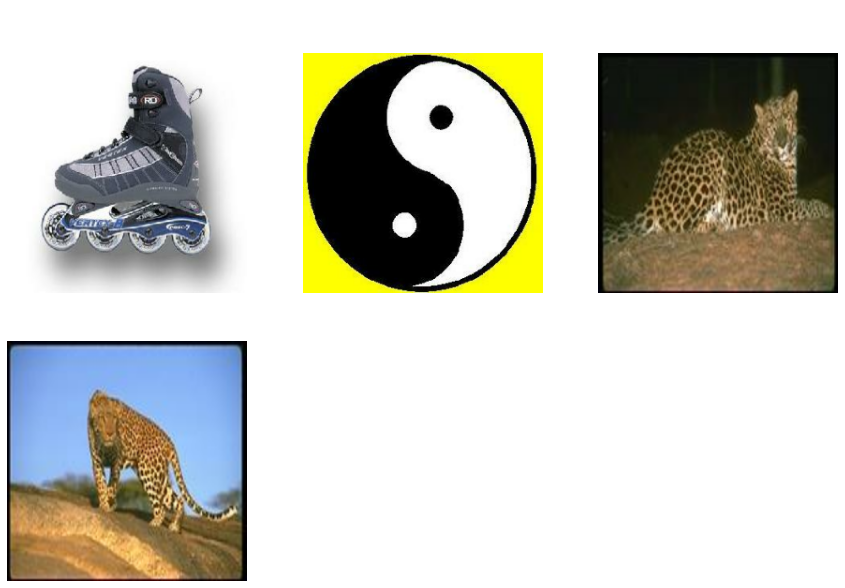

In [46]:
some_test_ds_predictions(fine_tuned_resnet101)

In [47]:
get_classification_report(fine_tuned_resnet101)

              precision    recall  f1-score   support

           0       0.10      0.10      0.10        49
           1       0.02      0.02      0.02        44
           2       0.05      0.05      0.05        41
           3       0.00      0.00      0.00        19
           4       0.04      0.04      0.04        80
           5       0.00      0.00      0.00         6
           6       0.07      0.07      0.07        69
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00        10
          17       0.00    

C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaroslav\PycharmProjects\NeuralNetworks\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

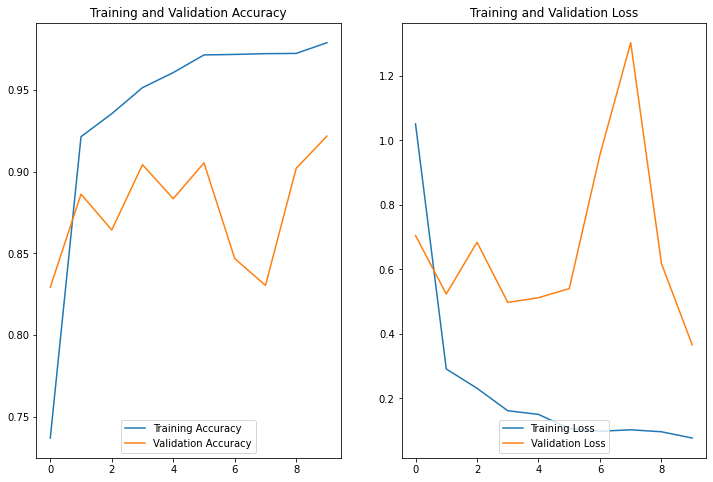

In [48]:
build_learning_curves(ft_history)

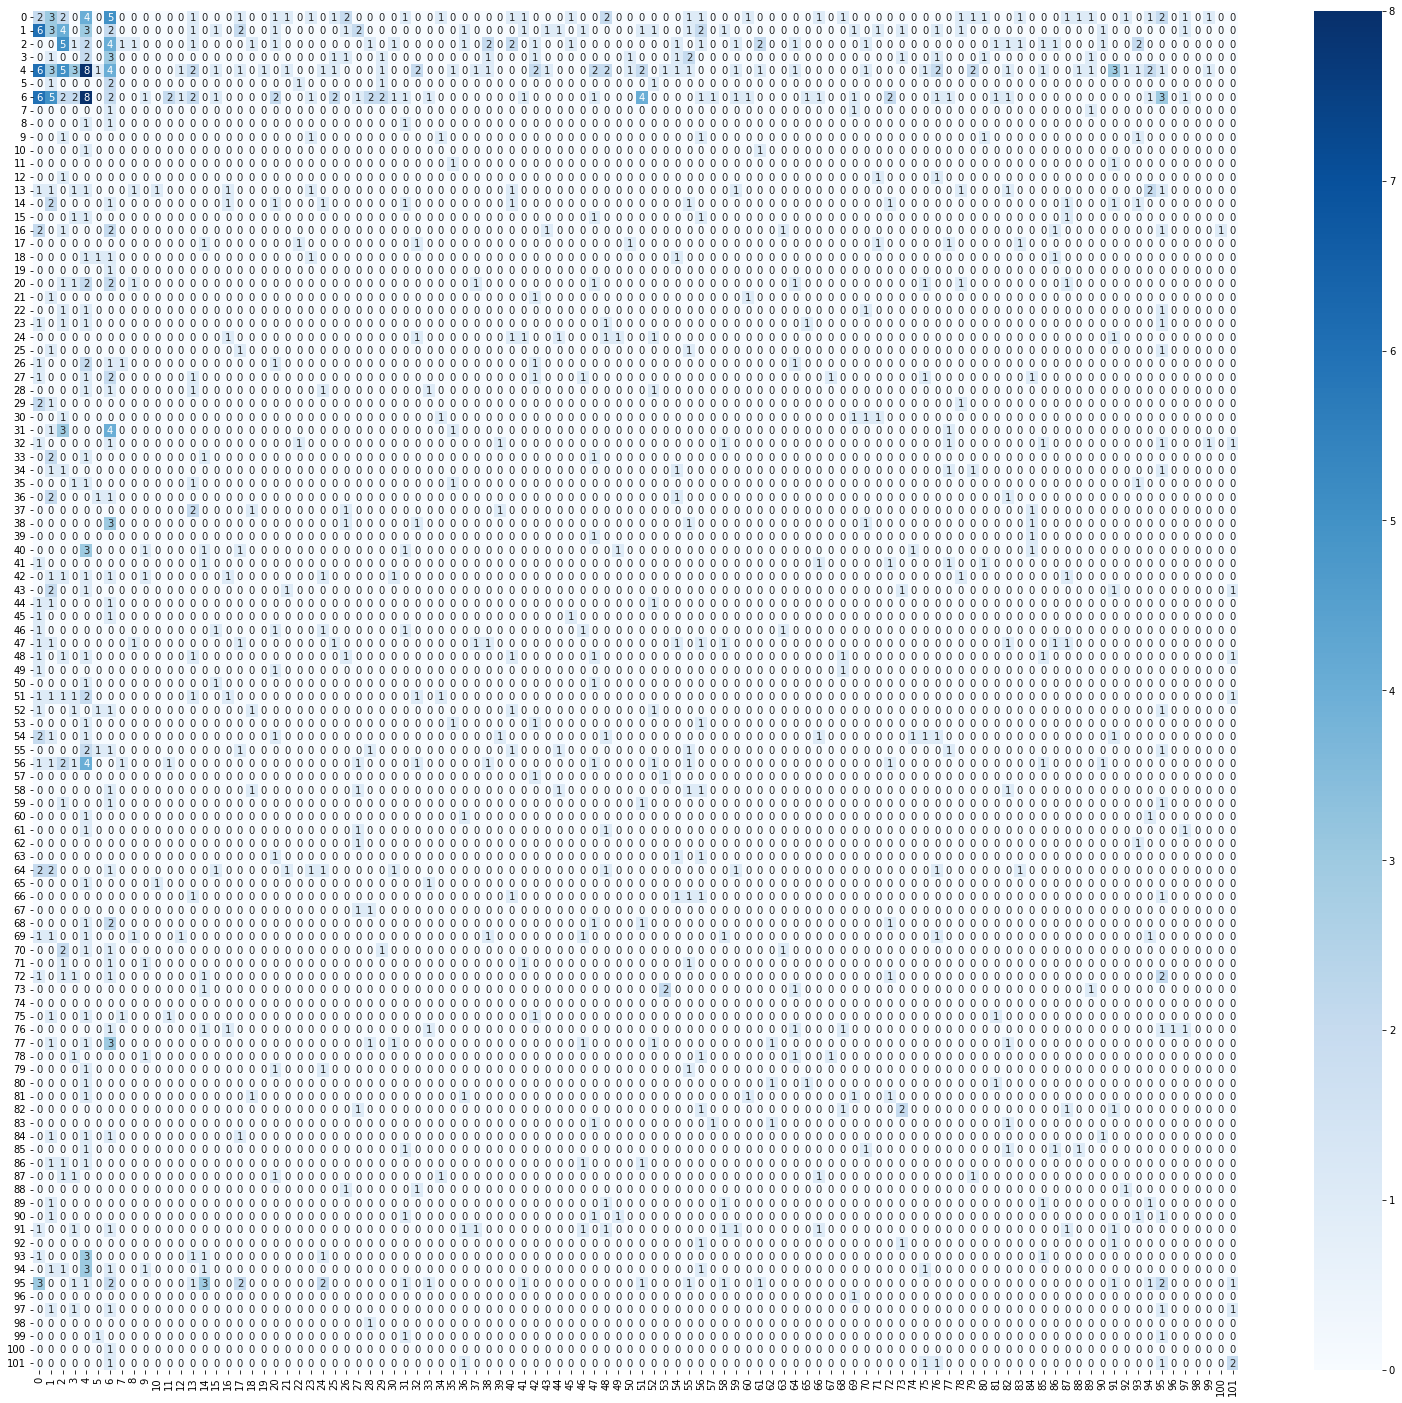

In [49]:
plot_confusion_matrix(fine_tuned_resnet101)

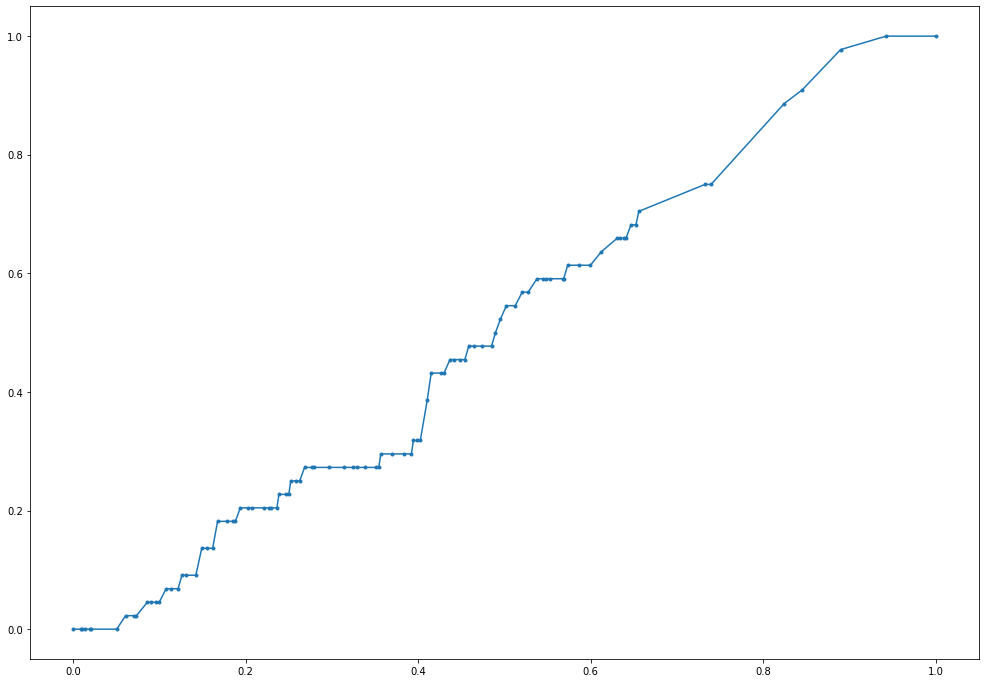

In [50]:
plot_roc_curve(fine_tuned_resnet101)

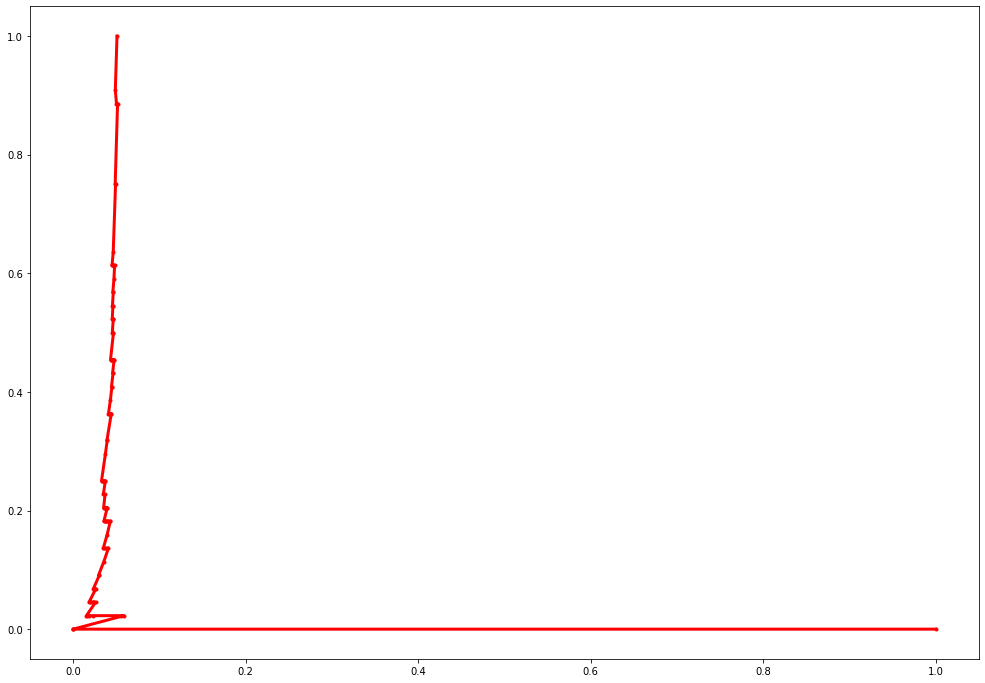

In [51]:
plot_precision_recall_curve(fine_tuned_resnet101)

First Conv2D layer
2


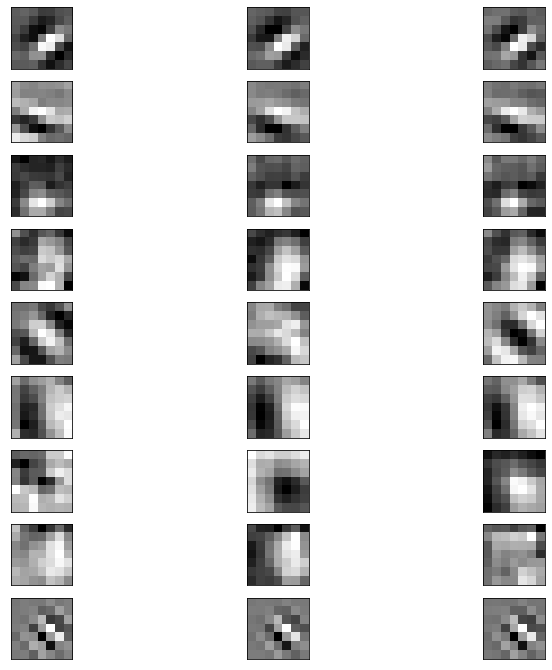

Second Conv2D layer
10


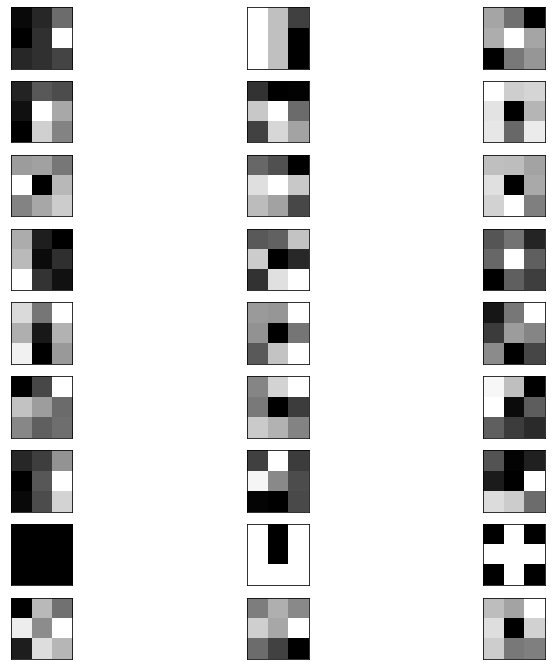

In [60]:
visualize_filters(fine_tuned_resnet101)

First Conv2D layer


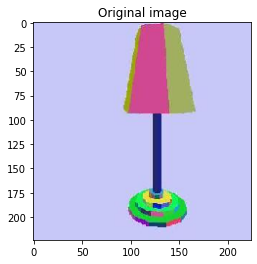

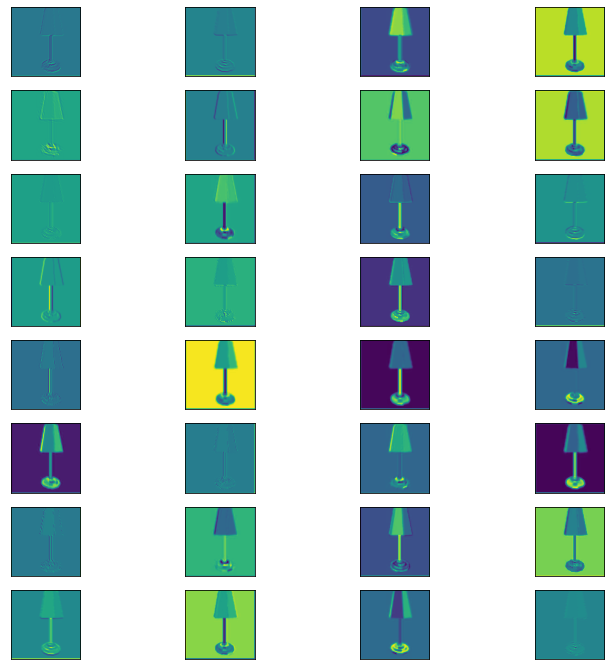

Second Conv2D layer


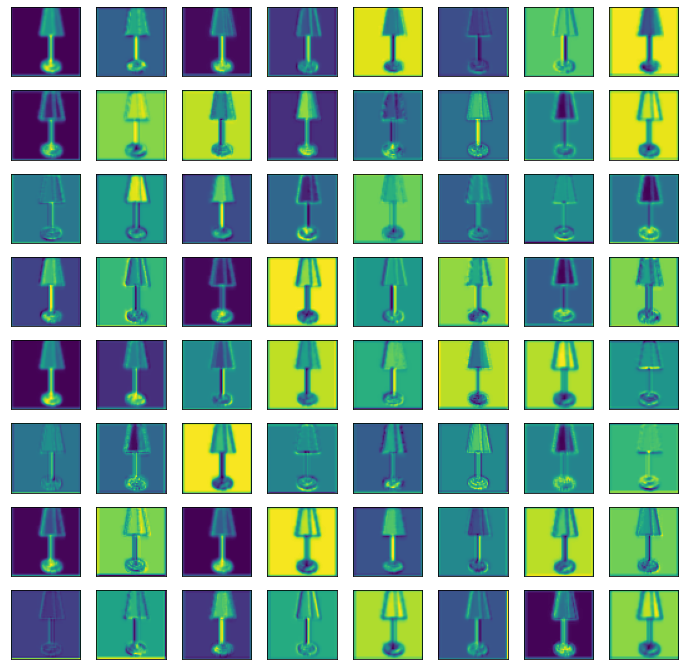

In [61]:
visualize_feature_maps(fine_tuned_resnet101)

In [56]:
fine_tuned_resnet101.save(f"models/fineTunedResNet")

INFO:tensorflow:Assets written to: models/fineTunedResNet\assets


# Explaining the results

###1. What kind of features did filters extract?

Some feature extract only horizontal lines or vertical, some of them only background or foreground and others even extract 3d objects shapes.

###2. Do you have "blind" filters that didn't learn anything? Why? How could you fix that?

Yes, I have. For example in the second convolutional layer in the fine-tuned resnet. I think this is kind of random thing, and we can't actually fix that, but its can be wrong suggestion.

###3. Does your model consider the background of the inputs?

Background is analyzed by neural network as well.

###4. Does your model consider the color of the inputs?

Yes, but it is not required.